# Neural Network From Scratch – XOR & Gradient Checking

This notebook demonstrates:
- A minimal MLP solving the XOR problem.
- A simple gradient checking routine to verify backpropagation.

## 1. Setup

Import the custom library components from `lib/` and fix the random seed for reproducibility.

In [1]:
import numpy as np

from lib.layers import Dense
from lib.activations import Tanh
from lib.network import Network
from lib.losses import MSELoss
from lib.optimizer import SGD
from lib.gradcheck import gradient_check

# Reproducibility
np.random.seed(42)

## 2. XOR dataset

We define the classic XOR problem with inputs in {0, 1} and targets encoded in {-1, +1}.

In [2]:
# XOR inputs in {0, 1}
X_01 = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])

# XOR targets in {-1, +1}
y_true = np.array([
    [-1.0],
    [ 1.0],
    [ 1.0],
    [-1.0],
])

print("Original inputs (0/1):")
print(X_01)
print("\nTargets (-1/+1):")
print(y_true)

Original inputs (0/1):
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

Targets (-1/+1):
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


## 3. Input normalization to [-1, +1]

Since we use Tanh activations (range [-1, +1]) and targets in {-1, +1},
it is natural to also map the inputs from {0, 1} to {-1, +1}:

- 0 → -1
- 1 → +1

This keeps the whole network (inputs, activations, outputs) in a consistent range.

In [3]:
# Map inputs from {0, 1} to {-1, +1}
X = 2.0 * X_01 - 1.0

print("Normalized inputs (-1/+1):")
print(X)

Normalized inputs (-1/+1):
[[-1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1.  1.]]


## 4. Network architecture

We build a small MLP for XOR:

- Input: 2 units
- Hidden layer: 4 units + Tanh
- Output layer: 1 unit + Tanh

Tanh is well aligned with both the normalized inputs and the {-1, +1} targets.

In [4]:
def build_xor_network():
    """
    Simple MLP for XOR: 2 -> 4 -> 1 with Tanh activations.
    """
    net = Network()
    net.add(Dense(2, 4))
    net.add(Tanh())
    net.add(Dense(4, 1))
    net.add(Tanh())
    return net


net = build_xor_network()
loss_fn = MSELoss()
optimizer = SGD(learning_rate=0.5)

## 5. Training loop

We train the network on the (normalized) XOR data using:

- Mean Squared Error (MSE) loss
- Stochastic Gradient Descent (SGD) optimizer

In [5]:
num_epochs = 5000
loss_history = []  # store loss per epoch

for epoch in range(num_epochs):
    # Forward
    y_pred = net.forward(X)

    # Loss
    loss = loss_fn.forward(y_pred, y_true)
    loss_history.append(loss)

    # Backward
    grad_loss = loss_fn.backward(y_pred, y_true)
    net.backward(grad_loss)

    # Update
    optimizer.step(net.get_params(), net.get_grads())

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} - loss: {loss:.6f}")

Epoch 500/5000 - loss: 0.000405
Epoch 1000/5000 - loss: 0.000188
Epoch 1500/5000 - loss: 0.000121
Epoch 2000/5000 - loss: 0.000089
Epoch 2500/5000 - loss: 0.000070
Epoch 3000/5000 - loss: 0.000057
Epoch 3500/5000 - loss: 0.000049
Epoch 4000/5000 - loss: 0.000042
Epoch 4500/5000 - loss: 0.000037
Epoch 5000/5000 - loss: 0.000033


## 6. Loss curve

We now plot the loss value over training epochs to visualize the optimization progress.

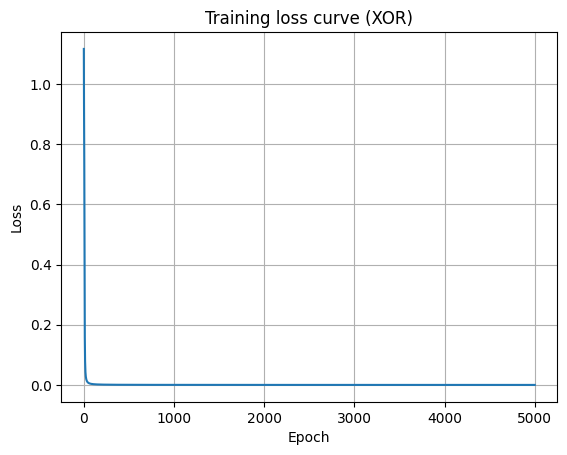

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss curve (XOR)")
plt.grid(True)
plt.show()

## 7. Evaluation on XOR

After training, we evaluate the network on the four XOR input patterns.
We inspect the raw Tanh outputs and convert them back to {-1, +1}.

In [7]:
y_pred = net.forward(X)

print("Raw outputs (Tanh):")
print(y_pred)

# Map Tanh outputs to class labels
y_decision = np.where(y_pred >= 0.0, 1.0, -1.0)

print("\nQuantized predictions (-1 / +1):")
print(y_decision)

print("\nTrue labels:")
print(y_true)

Raw outputs (Tanh):
[[-0.99433297]
 [ 0.99404573]
 [ 0.99407298]
 [-0.99442894]]

Quantized predictions (-1 / +1):
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]

True labels:
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


## 8. Why Tanh fits naturally with {-1, +1} inputs and outputs

We normalize the XOR inputs from {0,1} → {-1,+1}, and we encode targets as {-1,+1}.
This makes **Tanh** the most natural activation function because:

1. **Range alignment**
   - Tanh outputs lie in **[-1, +1]**
   - Both inputs and targets lie in **[-1, +1]**

2. **Zero-centered activations**
   - Tanh is centered at 0
   - Inputs are also centered at 0
   - This prevents biased gradients and often speeds up training

3. **Stable gradient flow**
   - Inputs that fall in the active region of Tanh avoid saturation
   - Backpropagation becomes numerically more stable

4. **Simple decision rule**
   - output ≥ 0 → +1
   - output < 0 → -1

This alignment between input domain, activation output, and target encoding
creates a more well-conditioned learning setup.

## 9. Gradient checking

Before trusting the training process, we must verify that backpropagation
was implemented correctly.

We compare:

- Analytical gradients (computed by `.backward`)
- Numerical gradients (finite difference)

The function `gradient_check` returns the maximum difference between both.


In [8]:
net_gc = build_xor_network()
loss_fn_gc = MSELoss()

max_diff = gradient_check(
    network=net_gc,
    loss_fn=loss_fn_gc,
    X=X,
    y_true=y_true,
    eps=1e-5,
)

print("Max absolute difference:", max_diff)

if max_diff < 1e-4:
    print("Gradient check PASSED")
else:
    print("Gradient check FAILED")

Max absolute difference: 1.9621443358985857e-11
Gradient check PASSED


### Gradient checking summary

To ensure that the backpropagation implementation is correct,
we performed numerical gradient checking on the XOR network.

The maximum absolute difference between analytical and numerical
gradients was on the order of 1e-11, which confirms that the
gradients are implemented correctly.